# Stock Analysis 2: Further Development of Indicator and Pattern Recognition

In the previous notebook I have explored the capablity of using python to do algorithmic trading and computing resistance/support lines and other indicators. In this notebook I want to further develop more sophisticated scheme to identify common patterns which are frequently used in technical analysis.

Written by Shing Chi Leung at 4 February 2021

# 1. Preparation

I will need to download the necessary modules and the stock historical price data for my study.

In [ ]:
# additional for running on google Colab

!pip install yfinance
!pip install mpl_finance

     |████████████████████████████████| 5.5MB 6.0MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.55-py2.py3-none-any.whl size=22616 sha256=91f8865d513ca94bc6dc4217e65432d406f5fc9c5a21587ee148f931672b7770
  Stored in directory: /root/.cache/pip/wheels/04/98/cc/2702a4242d60bdc14f48b4557c427ded1fe92aedf257d4565c
Successfully built yfinance
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [ ]:
import yfinance as yf
import matplotlib.pyplot as plt

from mpl_finance import candlestick2_ochl

import numpy as np
import pandas as pd
from statistics import mean, stdev 

import matplotlib.pyplot as plt

import datetime

In [ ]:
from google.colab import drive
drive.mount("gdrive")

Mounted at gdrive


In [ ]:
# Global parameter setting

directory = "gdrive/MyDrive/Colab Notebooks/"

# define symbol
stock_symbol = "ALNY"

start_date = '2020-1-1'
end_date = datetime.date.today() - datetime.timedelta(days=5)

In [ ]:
# get from yfinance the historical data
print("Getting data from {} to {}\n".format(start_date, end_date))

# get data
df_stock = yf.download(stock_symbol, start=start_date, end=end_date)
df_stock.reset_index(inplace=True)

print(type(df_stock))

print(df_stock.head(5))
print(df_stock.tail(5))

Getting data from 2020-1-1 to 2021-02-01

[*********************100%***********************]  1 of 1 completed
<class 'pandas.core.frame.DataFrame'>
        Date        Open        High  ...       Close   Adj Close  Volume
0 2020-01-02  115.570000  117.599998  ...  115.620003  115.620003  593500
1 2020-01-03  114.230003  116.930000  ...  115.680000  115.680000  426000
2 2020-01-06  115.150002  116.959999  ...  115.970001  115.970001  668600
3 2020-01-07  115.970001  117.019997  ...  115.290001  115.290001  392300
4 2020-01-08  115.410004  116.379997  ...  115.470001  115.470001  554400

[5 rows x 7 columns]
          Date        Open        High  ...       Close   Adj Close   Volume
267 2021-01-25  170.429993  176.779999  ...  175.690002  175.690002  1158000
268 2021-01-26  174.149994  178.410004  ...  170.020004  170.020004   539600
269 2021-01-27  168.580002  168.889999  ...  155.389999  155.389999  1249200
270 2021-01-28  157.500000  157.500000  ...  154.740005  154.740005   829800


In [ ]:
# saving the historical data to drive

# save the tickerData to csv
file_path = directory + stock_symbol+"_price.csv"

df_stock.to_csv(file_path)

In [ ]:
# reading the historical data from drive

# read the csv file to tickerData
file_path = directory + stock_symbol+"_price.csv"

df_stock = pd.read_csv(file_path)
print(df_stock.head())

Text(0.5, 0, 'Date')

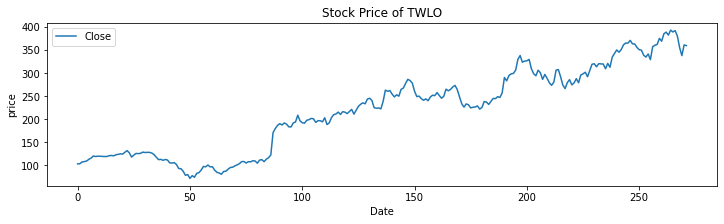

In [ ]:
ax1 = df_stock.plot.line(y=["Close", ], figsize=(12,3))

ax1.set_title("Stock Price of " + stock_symbol)
ax1.set_ylabel("price")
ax1.set_xlabel("Date")

#start_date = datetime.strptime("2019-01-01", "%Y-%M-%d")
#end_date = datetime.strptime("2021-01-01", "%Y-%M-%d")
#ax1.set_xlim(start_date, end_date)

We need to add some essential indicators first for our following analysis

# 2a. Simple Exponential Moving Average

Text(0.5, 0, 'Date')

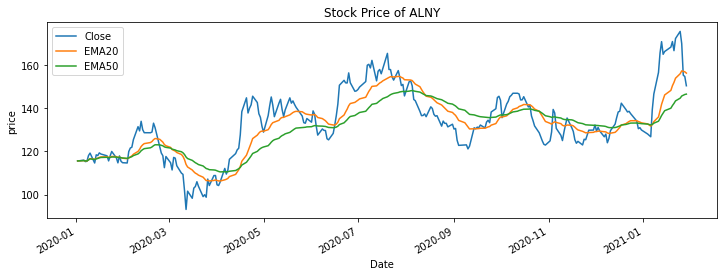

In [ ]:
df_stock["EMA20"] = df_stock["Close"].ewm(span=20).mean()
df_stock["EMA50"] = df_stock["Close"].ewm(span=50).mean()

ax2 = df_stock.plot.line(x="Date", y=["Close", "EMA20", "EMA50"], figsize=(12,4))

ax2.set_title("Stock Price of " + stock_symbol)
ax2.set_ylabel("price")
ax2.set_xlabel("Date")


# 2b. Support Resistance Line Finder

First I want to improve the support line finder that the line should be limited to the price events, but not everywhere. 

In [ ]:
# some universal parameter for searching the resistance and support lines

window = 5

threshold = 0.02

In [ ]:
stock_hl = df_stock[["Date", "Close", "Volume"]].to_numpy()

local_maxs = []

# find a local minimum in a window of 5
for i in range(window, stock_hl.shape[0]-window-1, 1):
  #if stock_hl[i,2] < stock_hl[i-1,2] and stock_hl[i,2] < stock_hl[i-2,2] and \
  #  stock_hl[i,2] < stock_hl[i+1,2] and stock_hl[i,2] < stock_hl[i+2,2]:
  idx = np.argmax(stock_hl[i-window:i+window+1,1])
  local_maxs.append(stock_hl[i-window+idx,:])

# process the resistance points, but will not be used if processing the support points together

res_points = []

# remove minimum of similar price
while local_maxs != []:

  global_max = max(local_maxs, key=lambda x: x[1])
  local_maxs = [(a,b,c) for a,b,c in local_maxs if global_max[0]!=a]

  loc_res_points = [global_max]
  for i in range(len(local_maxs)-1,-1,-1):
    if abs(local_maxs[i][1] - global_max[1]) / global_max[1] < threshold:
      loc_res_points.append(local_maxs[i])
      local_maxs.pop(i)

  res_value = mean([v[1] for v in loc_res_points])

  # define strength by volume
  #sup_strength = sum([loc_sup_point[2] for loc_sup_point in loc_sup_points])

  # define strength by frequency
  res_strength = len(loc_res_points)

  start_date_loc = min(loc_res_points, key=lambda x:x[0])[0]
  end_date_loc = max(loc_res_points, key=lambda x:x[0])[0]
  res_points.append([start_date_loc, end_date_loc, res_value, res_strength])


# sort the support points according to their prce
res_points.sort(key=lambda x:x[2], reverse=True)



In [ ]:
window = 5 # define on both side, left 10, right 10

stock_hl = df_stock[["Date", "Close", "Volume"]].to_numpy()

local_mins = []

# find a local minimum in a window of 5
for i in range(window, stock_hl.shape[0]-window-1, 1):
  #if stock_hl[i,2] < stock_hl[i-1,2] and stock_hl[i,2] < stock_hl[i-2,2] and \
  #  stock_hl[i,2] < stock_hl[i+1,2] and stock_hl[i,2] < stock_hl[i+2,2]:
  idx = np.argmin(stock_hl[i-window:i+window+1,1])
  local_mins.append(stock_hl[i-window+idx,:])

# process all local mins to get the essential support points

sup_points = []

# remove minimum of similar price
while local_mins != []:

  global_min = min(local_mins, key=lambda x: x[1])
  local_mins = [(a,b,c) for a,b,c in local_mins if global_min[0]!=a]

  loc_sup_points = [global_min]
  for i in range(len(local_mins)-1,-1,-1):
    if abs(local_mins[i][1] - global_min[1]) / global_min[1] < threshold:
      loc_sup_points.append(local_mins[i])
      local_mins.pop(i)

  sup_value = mean([v[1] for v in loc_sup_points])

  # define strength by volume
  #sup_strength = sum([loc_sup_point[2] for loc_sup_point in loc_sup_points])

  # define strength by frequency
  sup_strength = len(loc_sup_points)

  start_date_loc = min(loc_sup_points, key=lambda x:x[0])[0]
  end_date_loc = max(loc_sup_points, key=lambda x:x[0])[0]
  sup_points.append([start_date_loc, end_date_loc, sup_value, sup_strength])


# sort the support points according to their importance
sup_points.sort(key=lambda x:x[2], reverse=False)


In [ ]:
# combine the resistance and support point to make it unified
# filter the support points to find the minimum of minimum
grouped_points = []

while not (sup_points == [] and res_points == []):

  #print(len(res_points), len(sup_points))

  if sup_points != []:
    selected_points = [sup_points[0]]
    sup_points.pop(0)
  else:
    selected_points = [res_points[0]]
    res_points.pop(0)

  # if there are extra points from both sides which mactch the price
  # bring them together 
  for i in range(len(res_points)-1,-1,-1):
    curr_max = max(selected_points, key=lambda x:x[2])[2]
    curr_min = max(selected_points, key=lambda x:x[2])[2]
    if abs(curr_max - res_points[i][2]) / res_points[i][2] < threshold or \
      abs(curr_min - res_points[i][2]) / res_points[i][2] < threshold:
      selected_points.append(res_points[i])
      res_points.pop(i)

  for i in range(len(sup_points)-1,-1,-1):
    curr_max = max(selected_points, key=lambda x:x[2])[2]
    curr_min = max(selected_points, key=lambda x:x[2])[2]
    if abs(curr_max - sup_points[i][2]) / sup_points[i][2] < threshold or \
      abs(curr_min - sup_points[i][2]) / sup_points[i][2] < threshold:
      selected_points.append(sup_points[i])
      sup_points.pop(i)

  #print(len(res_points), selected_points)  
  selected_value = mean([v[2] for v in selected_points])

  # define strength by volume
  #sup_strength = sum([loc_sup_point[2] for loc_sup_point in loc_sup_points])

  # define strength by frequency
  selected_strength = len(loc_res_points)

  start_date_loc = min(selected_points, key=lambda x:x[0])[0]
  end_date_loc = max(selected_points, key=lambda x:x[0])[1]
  grouped_points.append([start_date_loc, end_date_loc, selected_value, selected_strength])

#grouped_points = [point for point in grouped_points if point[0] != point[1]]
grouped_points = np.array(grouped_points)

#print(grouped_points)


# 2c. Bollinger Band Finder

Text(0.5, 0, 'Date')

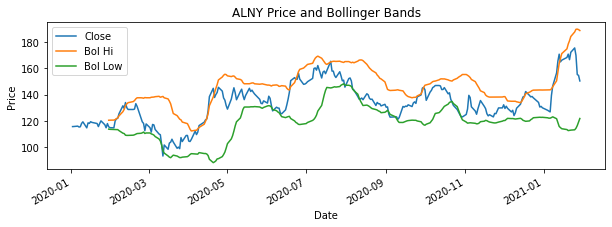

In [ ]:
#Bollinger Band

span = 20

df_stock["Mean"] = df_stock["Close"].rolling(window=span).mean()
df_stock["Std"] = df_stock["Close"].rolling(window=span).std()

df_stock["Bol Hi"] = df_stock["Mean"] + df_stock["Std"] * 2
df_stock["Bol Low"] = df_stock["Mean"] - df_stock["Std"] * 2

ax3 = df_stock.plot.line(x="Date", y=["Close", "Bol Hi", "Bol Low"], figsize=(10,3))

ax3.set_title(stock_symbol + " Price and Bollinger Bands")
ax3.set_ylabel("Price")
ax3.set_xlabel("Date")

# 2d. Linear Regression of Historical Data

In [ ]:
# get the linear trend line

# first get the linear regression of past 120 day (half year)

from sklearn.linear_model import LinearRegression
from math import sqrt

window_reg = 100

regressor = LinearRegression()

close_prices = list(df_stock["Close"].iloc[-window_reg:])

X = [[i] for i in range(window_reg)]
y = close_prices

regressor.fit(X, y)

# in the form y = mx + b
m = regressor.coef_[0]
b = regressor.intercept_

print("m = {} and b = {}".format(m, b))

dev = 0
for i in range(window_reg):
  dev += (df_stock["Close"].iloc[-100+i] - (m * i + b))**2

dev = sqrt(dev / window_reg)



m = 0.20545576345659475 and b = 127.53393926639367


In [ ]:
# Make the upper and lower regression lines

reg_line = [m * i + b for i in range(window_reg)]

dates = list(df_stock["Date"].iloc[-window_reg:])
upper_reg_lines = np.array(list(zip(dates, [m * i + b + 1.5 * dev for i in range(window_reg)])))
lower_reg_lines = np.array(list(zip(dates, [m * i + b - 1.5 * dev for i in range(window_reg)])))

#print(upper_reg_lines)


# 2e. Channel Finding

In [ ]:
window_monthly = 20

print(df_stock.shape)
df_stock["Monthly Max"] = df_stock["Close"].rolling(window=window_monthly).max()
df_stock["Monthly Min"] = df_stock["Close"].rolling(window=window_monthly).min()

#print(df_stock)

# then count the monthly max and min to identify stationary extrema and passing extrema
df_stock_maxima = df_stock.groupby("Monthly Max").size()
df_stock_maxima = df_stock_maxima[df_stock_maxima > 5]

#print(df_stock_maxima, df_stock_maxima.index)

# get the last three extrama on both sides and fetch the date and index
maxima_values = []
maxima_dates = []
maxima_idx = []

for i in range(df_stock.shape[0]-1,-1,-1):
  if df_stock["Close"].iloc[i] in df_stock_maxima.index:
    maxima_values.append(df_stock["Close"].iloc[i])
    maxima_dates.append(df_stock["Date"].iloc[i])
    maxima_idx.append(i)
  if len(maxima_dates) >= 3:
    break

print("{}\n".format(df_stock_maxima))

# Repeat the procedure of the minima
df_stock_minima = df_stock.groupby("Monthly Min").size()
df_stock_minima = df_stock_minima[df_stock_minima > 5]
print("{}\n".format(df_stock_minima))

minima_values = []
minima_dates = []
minima_idx = []

for i in range(df_stock.shape[0]-1,-1,-1):
  if df_stock["Close"].iloc[i] in df_stock_minima.index:
    minima_values.append(df_stock["Close"].iloc[i])
    minima_dates.append(df_stock["Date"].iloc[i])
    minima_idx.append(i)
  if len(minima_dates) >= 3:
    break


# shift the index of the first entry to zero
maxima_idx0 = maxima_idx[0]
maxima_idx = [[idx - maxima_idx0] for idx in maxima_idx]

minima_idx0 = minima_idx[0]
minima_idx = [[idx - minima_idx0] for idx in minima_idx]

# do another regression for these trends
reg_max = LinearRegression()
reg_min = LinearRegression()

reg_max.fit(maxima_idx, maxima_values)
reg_min.fit(minima_idx, minima_values)

# get the slope and intercepts for these lines
m_max = reg_max.coef_[0]
b_max = reg_max.intercept_

m_min = reg_min.coef_[0]
b_min = reg_min.intercept_

# form the lines 
max_reg_lines = np.array(list(zip(maxima_dates, [m_max * i[0] + b_max for i in maxima_idx])))
min_reg_lines = np.array(list(zip(minima_dates, [m_min * i[0] + b_min for i in minima_idx])))

print(max_reg_lines)

(272, 15)
Monthly Max
133.990005    20
135.509995     6
139.490005    11
140.699997     6
142.389999    13
144.869995    12
145.270004     8
145.600006     6
145.630005    20
147.000000    21
156.440002     7
162.250000     6
165.490005    20
dtype: int64

Monthly Min
93.120003     20
98.779999      7
114.650002     8
114.660004    11
121.190002    20
122.970001    20
123.019997    16
124.040001    11
125.389999    20
126.830002    14
128.970001    11
136.139999     6
147.910004     7
dtype: int64

[[Timestamp('2020-12-18 00:00:00') 141.7558492730274]
 [Timestamp('2020-11-13 00:00:00') 138.318373594729]
 [Timestamp('2020-11-04 00:00:00') 137.31577652189196]]


# 3. Data Visualization

Text(0.5, 1.0, 'Channels')

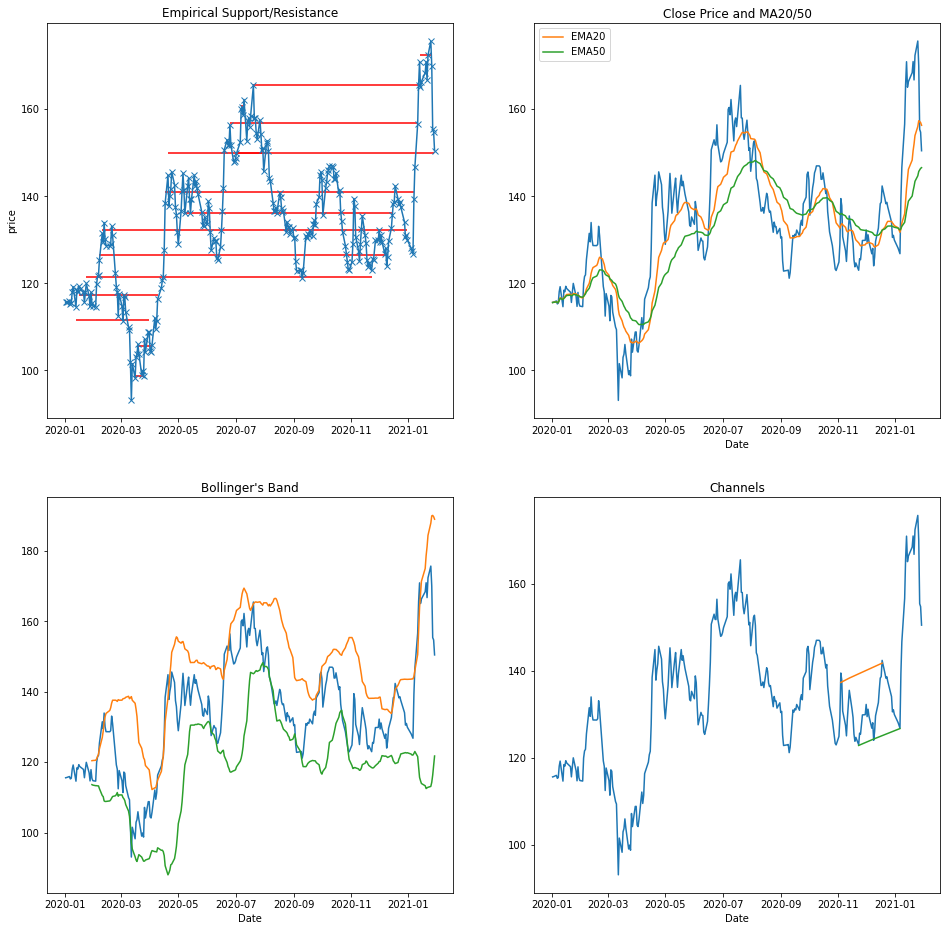

In [ ]:
fig1, ((ax1a, ax1b), (ax1c, ax1d)) = plt.subplots(figsize=(16,16), ncols=2, nrows=2)

ax1a.plot(df_stock["Date"], df_stock["Close"], "x-")

ax1a.set_title("Stock Price of " + stock_symbol)
#ax1.scatter(filtered_res_points[:,0], filtered_res_points[:,1], s=40)
ax1a.hlines(y=grouped_points[:,2], xmin=grouped_points[:,0], xmax=grouped_points[:,1], colors="red")

ax1b.plot(df_stock["Date"], df_stock[["Close"]])
ax1b.plot(df_stock["Date"], df_stock[["EMA20"]], label="EMA20")
ax1b.plot(df_stock["Date"], df_stock[["EMA50"]], label="EMA50")

ax1c.plot(df_stock["Date"], df_stock[["Close", "Bol Hi", "Bol Low"]])

ax1d.plot(df_stock["Date"], df_stock[["Close"]])
ax1d.plot(max_reg_lines[:,0], max_reg_lines[:,1])
ax1d.plot(min_reg_lines[:,0], min_reg_lines[:,1])

ax1a.set_ylabel("price")
ax1a.set_title("Empirical Support/Resistance")

ax1b.set_title("Close Price and MA20/50")
ax1b.set_xlabel("Date")
ax1b.legend()

ax1c.set_xlabel("Date")
ax1c.set_title("Bollinger's Band")

ax1d.set_xlabel("Date")
ax1d.set_title("Channels")

